In [42]:
import numpy as np
import pandas as pd
import plotnine as pn

from datetime import datetime, date

from sciterra.mapping.atlas import Atlas
from sciterra.mapping.cartography import Cartographer
from sciterra.vectorization.scibert import SciBERTVectorizer

In [43]:
# atlas_dir = "outputs/atlas_s2-7-19-23_centered_imeletal/"
# atlas_dir = "outputs/atlas_s2-7-19-23_centered_hafenetal/"
# atlas_dir = "outputs/atlas_s2-7-20-23_uncentered_imeletal/"
# atlas_dir = "outputs/atlas_from_cc_region_0/"
# atlas_dir = "outputs/atlas_from_cc_region_8/"
# atlas_dir = "outputs/atlas_ads-7-25-23_hafenetal"
# atlas_dir = "outputs/atlas_s2-7-29-23_centered_imeletal"
# atlas_dir = "outputs/atlas_s2-7-30-23_centered_hafenetal"
# atlas_dir = "outputs/atlas_s2-11-11-23_bow-centered_hafenetal"

In [3]:
# load atlas
# convert all datetimes to dates
# filter all pubs without citations
# measure density
# measure citations per year
# plot density against citation frequency

In [44]:
atl = Atlas.load(atlas_dir)

No history to read, skipping.
No center to read, skipping.


In [11]:
len(atl)

10098

In [12]:
vectorizer = SciBERTVectorizer(device="mps")
crt = Cartographer(vectorizer=vectorizer)

Using device: mps.


In [13]:
measurements = crt.measure_topography(atl, metrics=["density", "edginess"])

computing cosine similarity for 10098 embeddings with batch size 1000.


100%|██████████| 11/11 [00:31<00:00,  2.84s/it]
invalid value encountered in divide


Computing ['density', 'edginess'] for 10098 publications.


In [14]:
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in atl.projection.index_to_identifier

]
# what if we just drop all those with 0 citations (per year)?
# and those > 100 anyway
citations_per_year = [item if (item > 0. and item < 100.) else None for item in citations_per_year ]
# citations_per_year

In [18]:
# count zeros, i.e. where citation_count was zero
len(citations_per_year) - np.count_nonzero(citations_per_year)

1419

In [19]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year
df.dropna(inplace=True) # not sure why this didn't take care of later NaNs
df

density  edginess  citations_per_year
0      11.772887  0.557772            8.857143
1      17.622884  0.747825           16.083333
2      10.681719  0.660638           20.800000
3      13.926669  0.512978            6.000000
5      12.398308  0.682573           14.250000
...          ...       ...                 ...
10093  13.682448  0.691984            4.333333
10094  14.103222  0.686141            1.032258
10095  14.347957  0.557097            1.857143
10096  14.621789  0.712776            1.642857
10097  13.995957  0.631700            5.629630

[8597 rows x 3 columns]

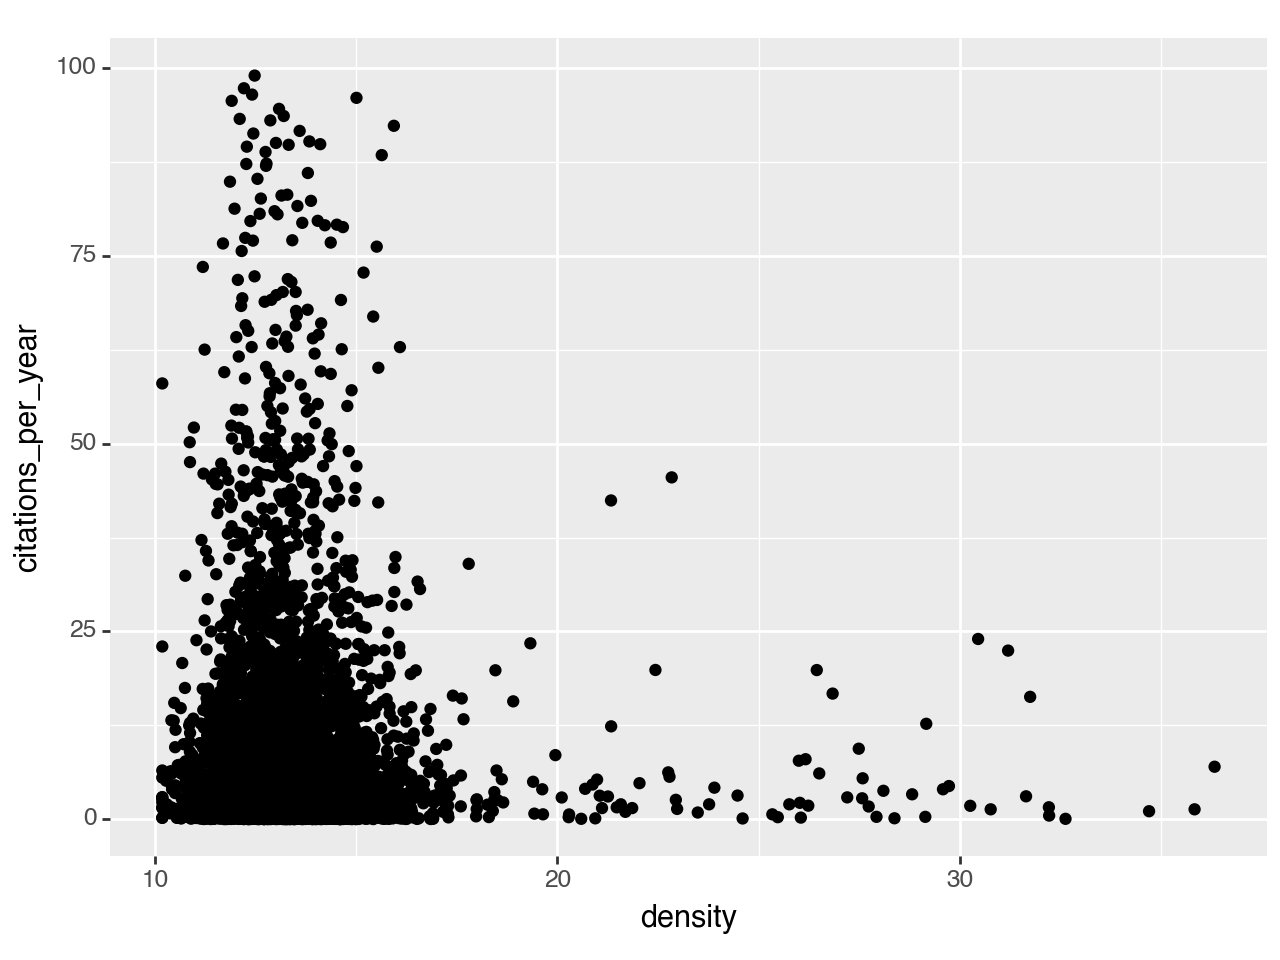

<Figure Size: (640 x 480)>

In [20]:
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point()
    # + pn.geom_smooth(color="orange")
)

In [29]:
# let's additionally drop all points with density > 40, assuming those will get tossed out by convergence check.
df = df[df["density"] < 20.]
df

density  edginess  citations_per_year   log_cpy
0      11.772887  0.557772            8.857143  0.947294
1      17.622884  0.747825           16.083333  1.206376
2      10.681719  0.660638           20.800000  1.318063
3      13.926669  0.512978            6.000000  0.778151
5      12.398308  0.682573           14.250000  1.153815
...          ...       ...                 ...       ...
10093  13.682448  0.691984            4.333333  0.636822
10094  14.103222  0.686141            1.032258  0.013788
10095  14.347957  0.557097            1.857143  0.268845
10096  14.621789  0.712776            1.642857  0.215600
10097  13.995957  0.631700            5.629630  0.750480

[8532 rows x 4 columns]

geom_point : Removed 432 rows containing missing values.


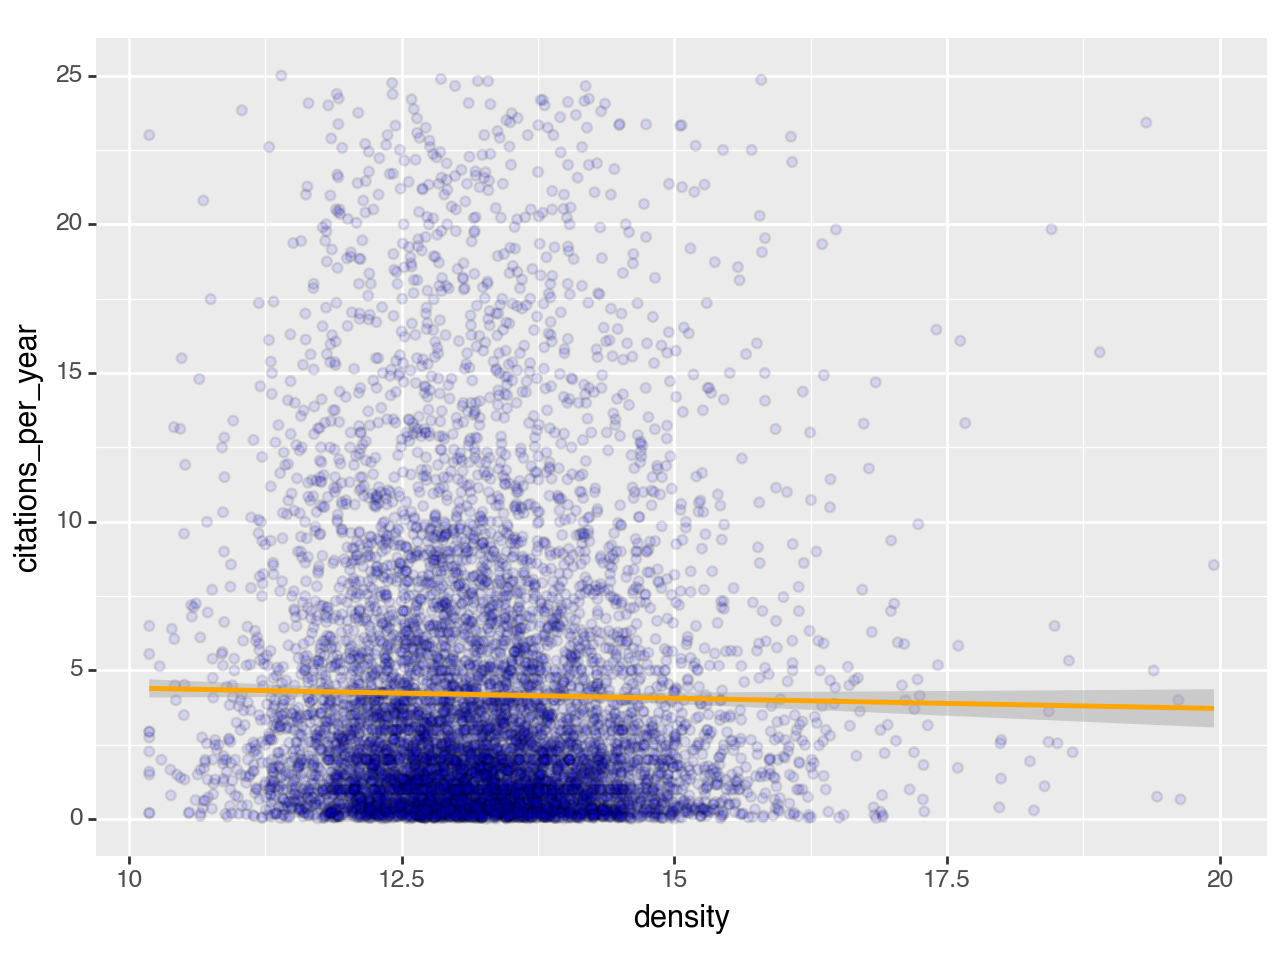

<Figure Size: (640 x 480)>

In [30]:
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    + pn.ylim(0, 25)
)

maybe the reason it seems like citations increase with density is actually not so interesting:

maybe it's that most papers just get few citations and are in the lower to mid range of density. Then when you get to higher density, there citation distribution just becomes more uniform. 

maybe. But why doesn't this argument apply in the other direction -- why does the citations not become more uniform at lower density?


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


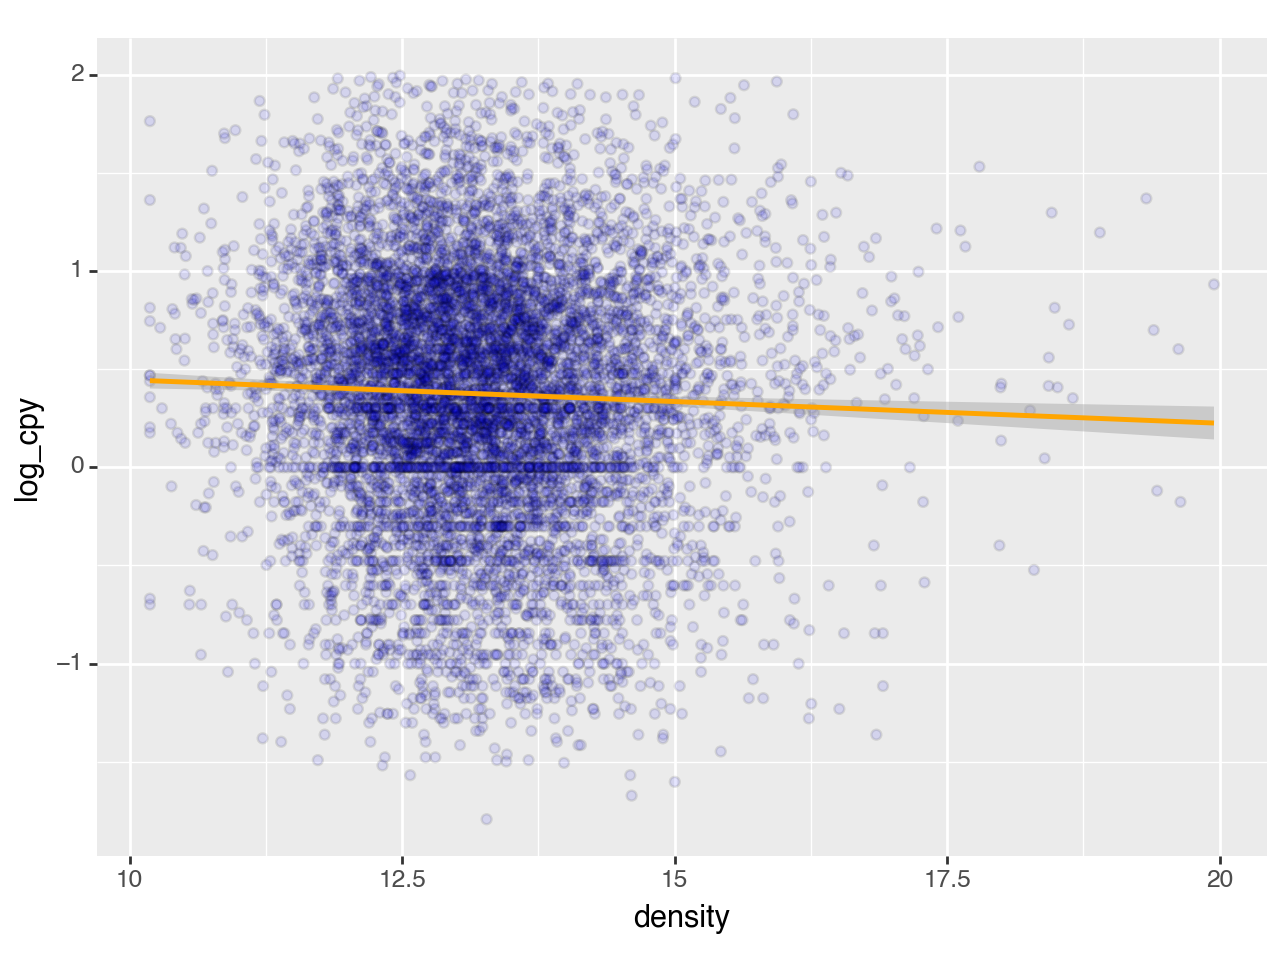

<Figure Size: (640 x 480)>

In [31]:
# log?
df["log_cpy"] = np.log10(df["citations_per_year"])
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 20)
)

geom_point : Removed 1336 rows containing missing values.


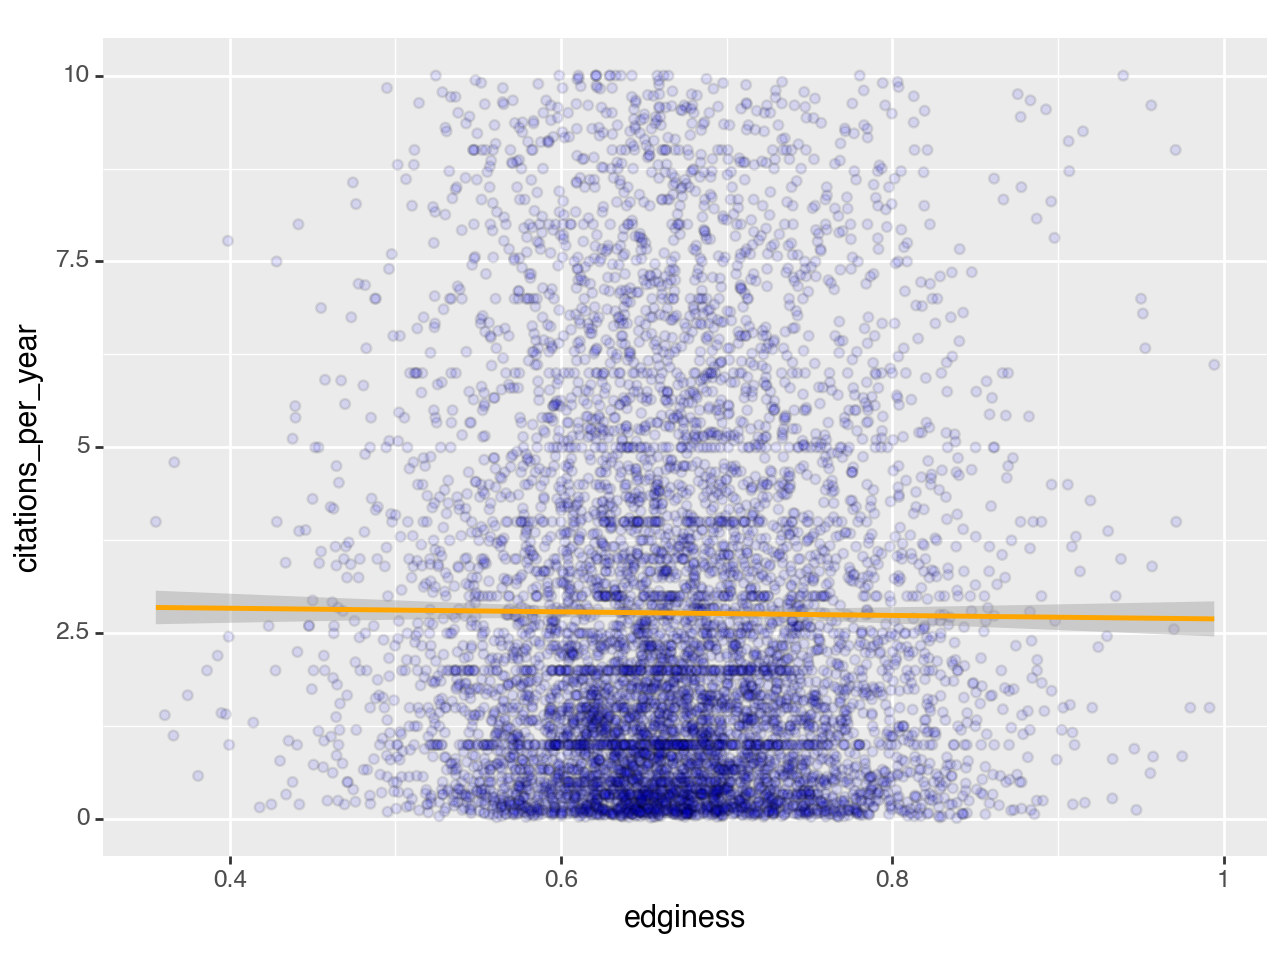

<Figure Size: (640 x 480)>

In [32]:
# asymmetry

(
    pn.ggplot(
        df,
        mapping=pn.aes(x="edginess", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    # + pn.ylim(0, 100)
    + pn.ylim(0, 10)
)

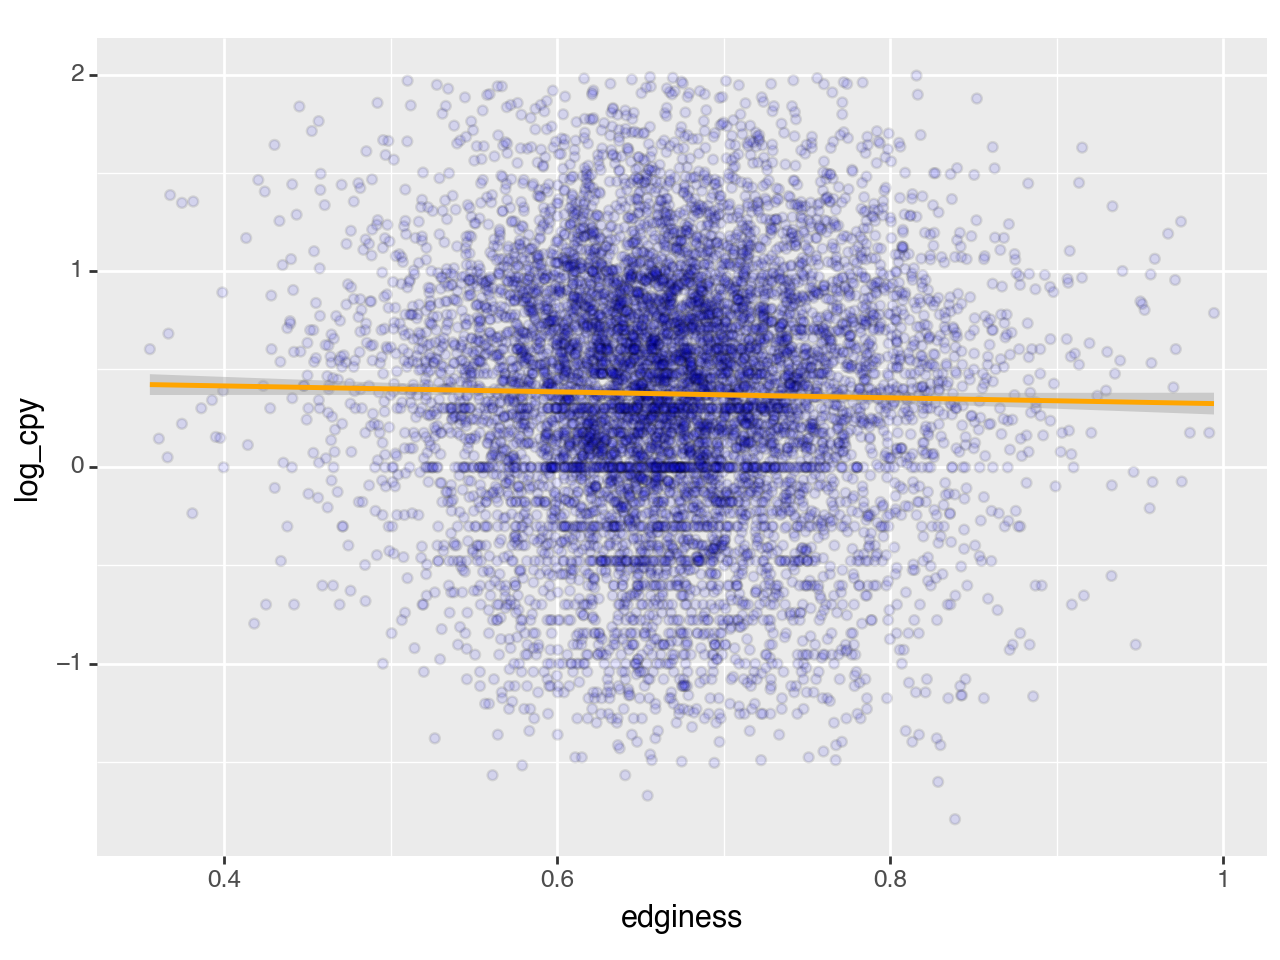

<Figure Size: (640 x 480)>

In [33]:
# asymmetry

(
    pn.ggplot(
        df,
        mapping=pn.aes(x="edginess", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    # + pn.ylim(0, 100)
)

normalizem

In [34]:
normalize = lambda arr: (arr - np.nanmean(arr)) / np.nanstd(arr)

density = normalize(df["density"])
edginess = normalize(df["edginess"])

In [35]:
df_n = pd.DataFrame(
    list(zip(density, edginess, citations_per_year, df["log_cpy"])),
    columns=["density", "edginess", "citations_per_year", "log_cpy"],
)
df_n

density  edginess  citations_per_year   log_cpy
0    -1.303761 -1.306662            8.857143  0.947294
1     3.933436  0.962175           16.083333  1.206376
2    -2.280627 -0.078655           20.800000  1.318063
3     0.624408 -1.841403            6.000000  0.778151
4    -0.743855  0.183203                 NaN  1.153815
...        ...       ...                 ...       ...
8527  0.405769  0.295550            1.000000  0.636822
8528  0.782466  0.225794            2.000000  0.013788
8529  1.001565 -1.314719                 NaN  0.268845
8530  1.246712  0.543762            1.125000  0.215600
8531  0.686438 -0.424117                 NaN  0.750480

[8532 rows x 4 columns]

geom_point : Removed 1272 rows containing missing values.


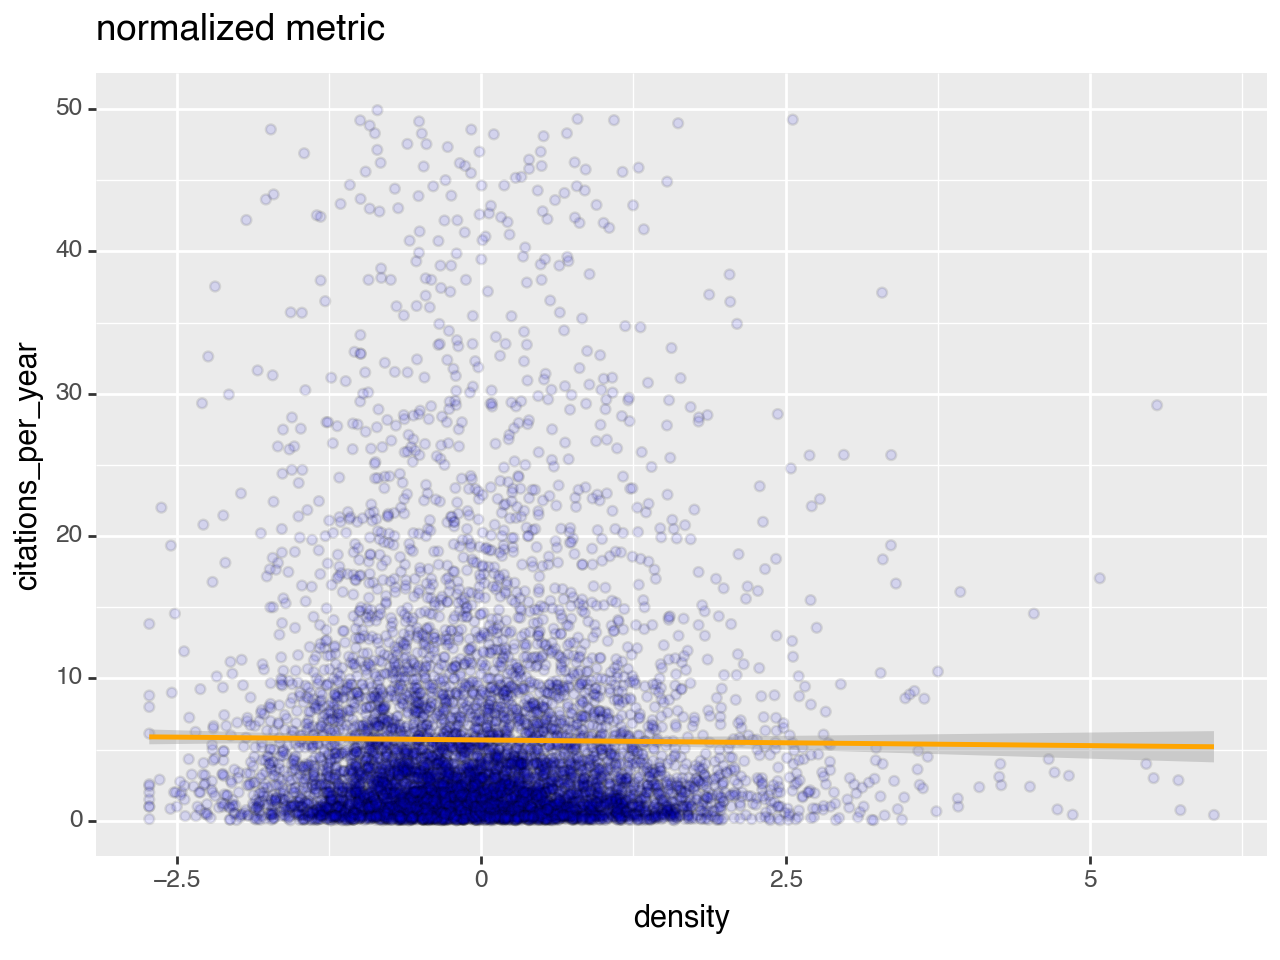

<Figure Size: (640 x 480)>

In [37]:
# This doesn't make much sense because edginess is already normalized to 0,1
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(0, 5)
    + pn.ylim(0, 50)
    + pn.ggtitle("normalized metric")
)

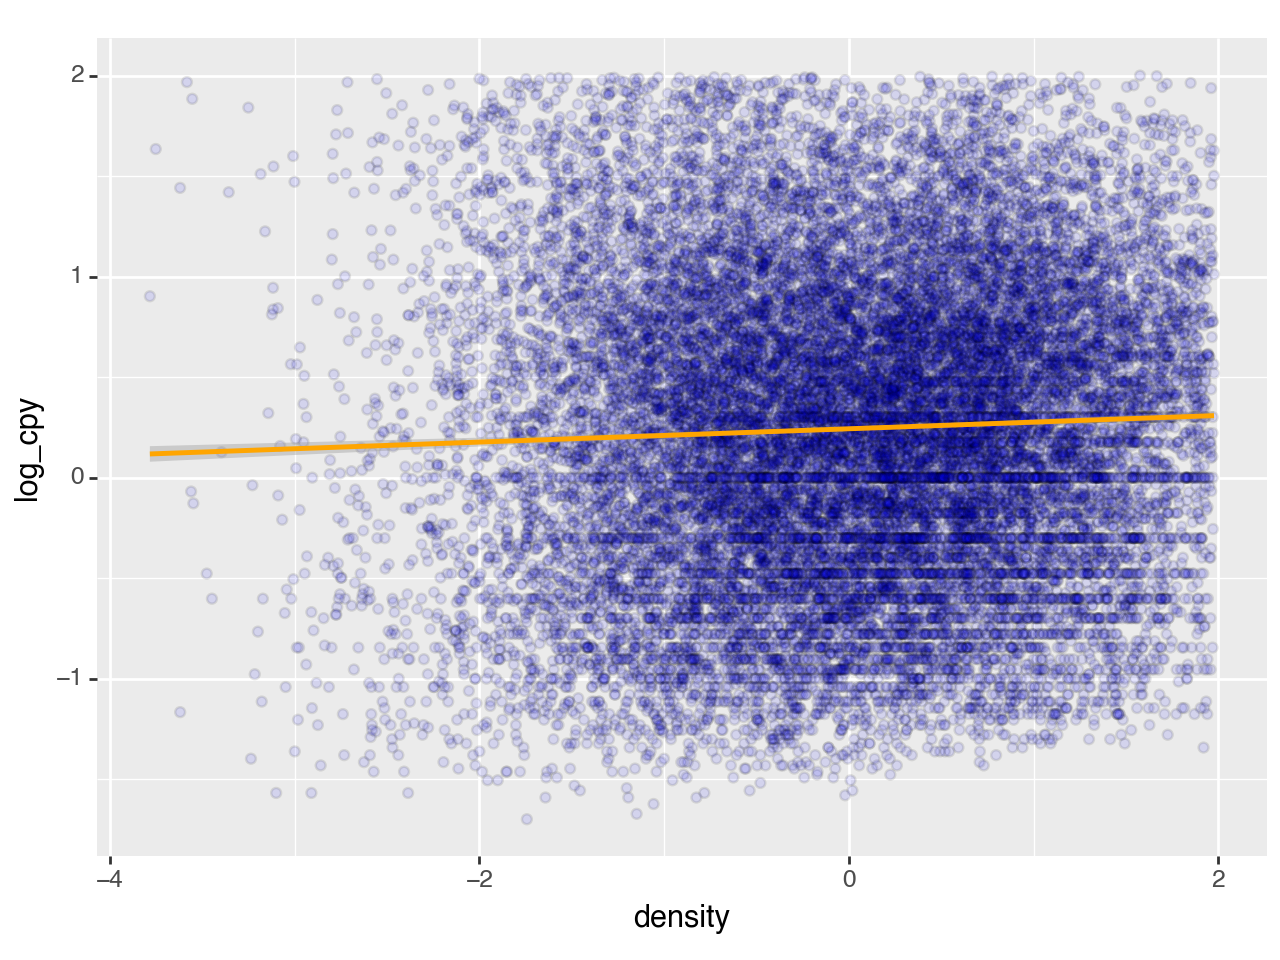

<Figure Size: (640 x 480)>

In [ ]:
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="density", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 20)
)

geom_point : Removed 7752 rows containing missing values.


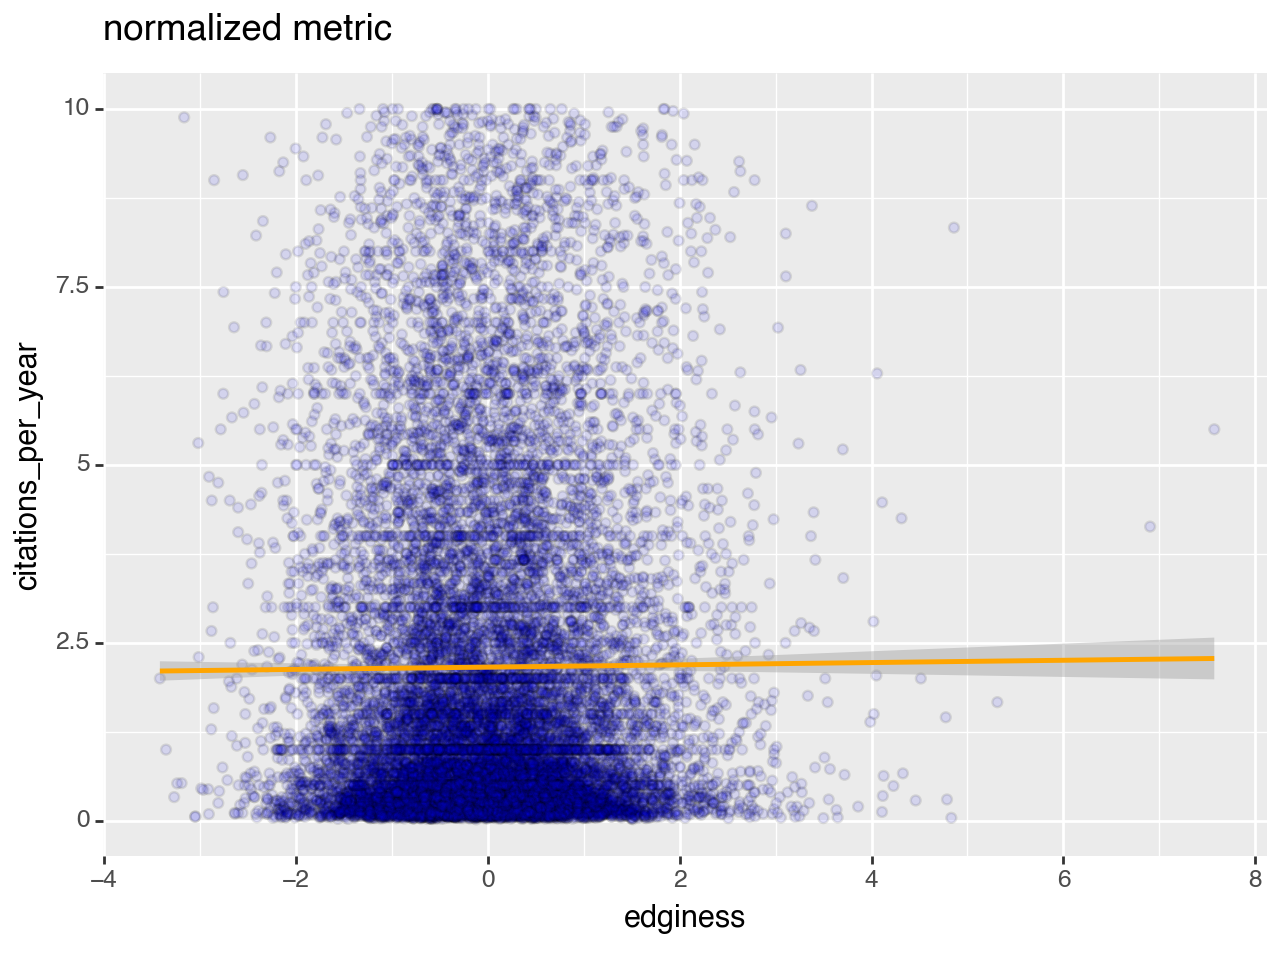

<Figure Size: (640 x 480)>

In [ ]:
# This doesn't make much sense because edginess is already normalized to 0,1
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="edginess", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    + pn.ylim(0, 10)
    + pn.ggtitle("normalized metric")
)

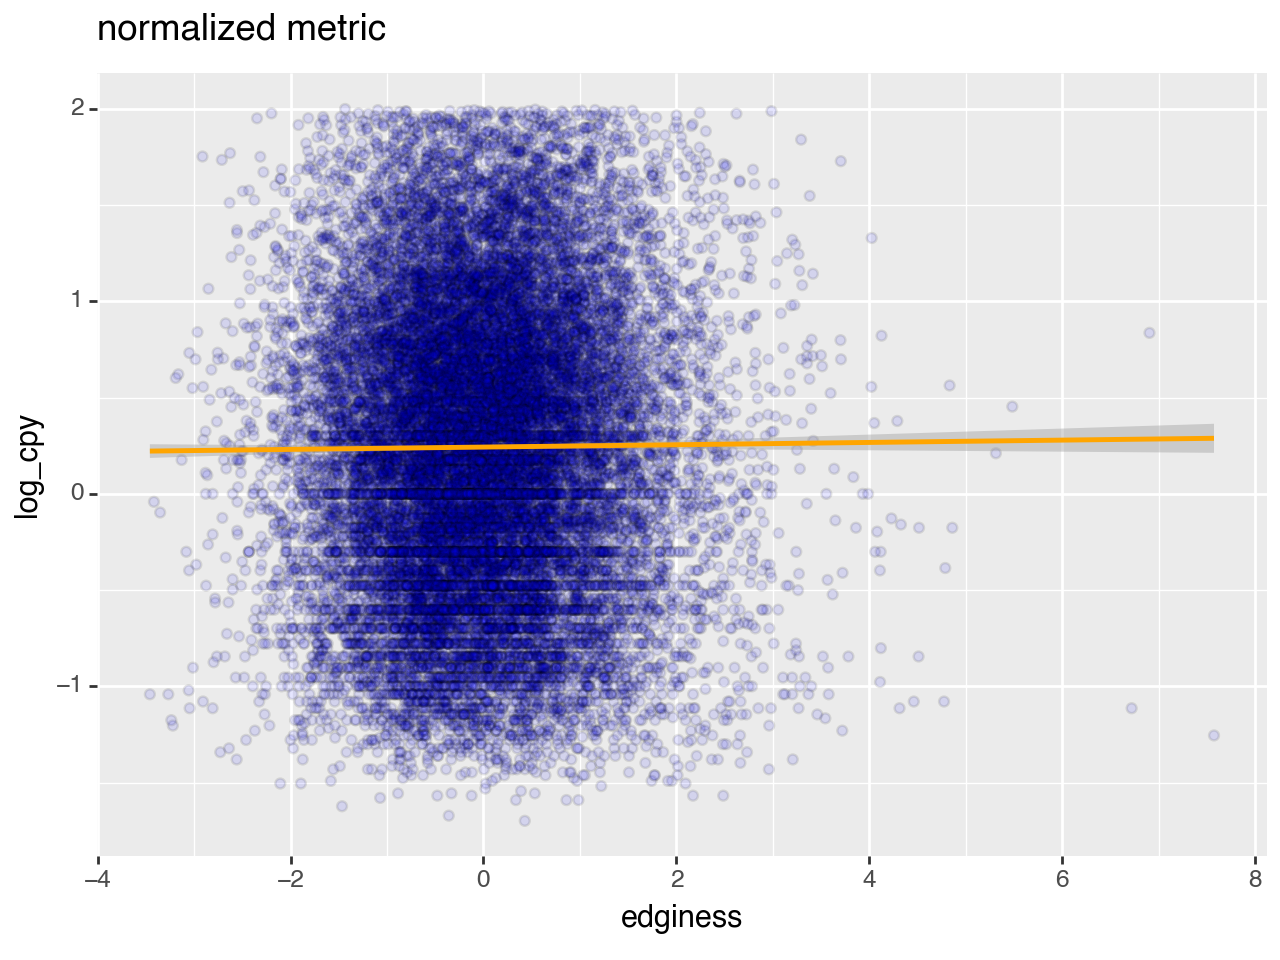

<Figure Size: (640 x 480)>

In [ ]:
# This doesn't make much sense because edginess is already normalized to 0,1
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="edginess", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    + pn.ggtitle("normalized metric")
)

In [38]:
np.std(df["citations_per_year"])

10.992828231422926

In [39]:
np.mean(df["citations_per_year"])

6.269150198864669

against each other

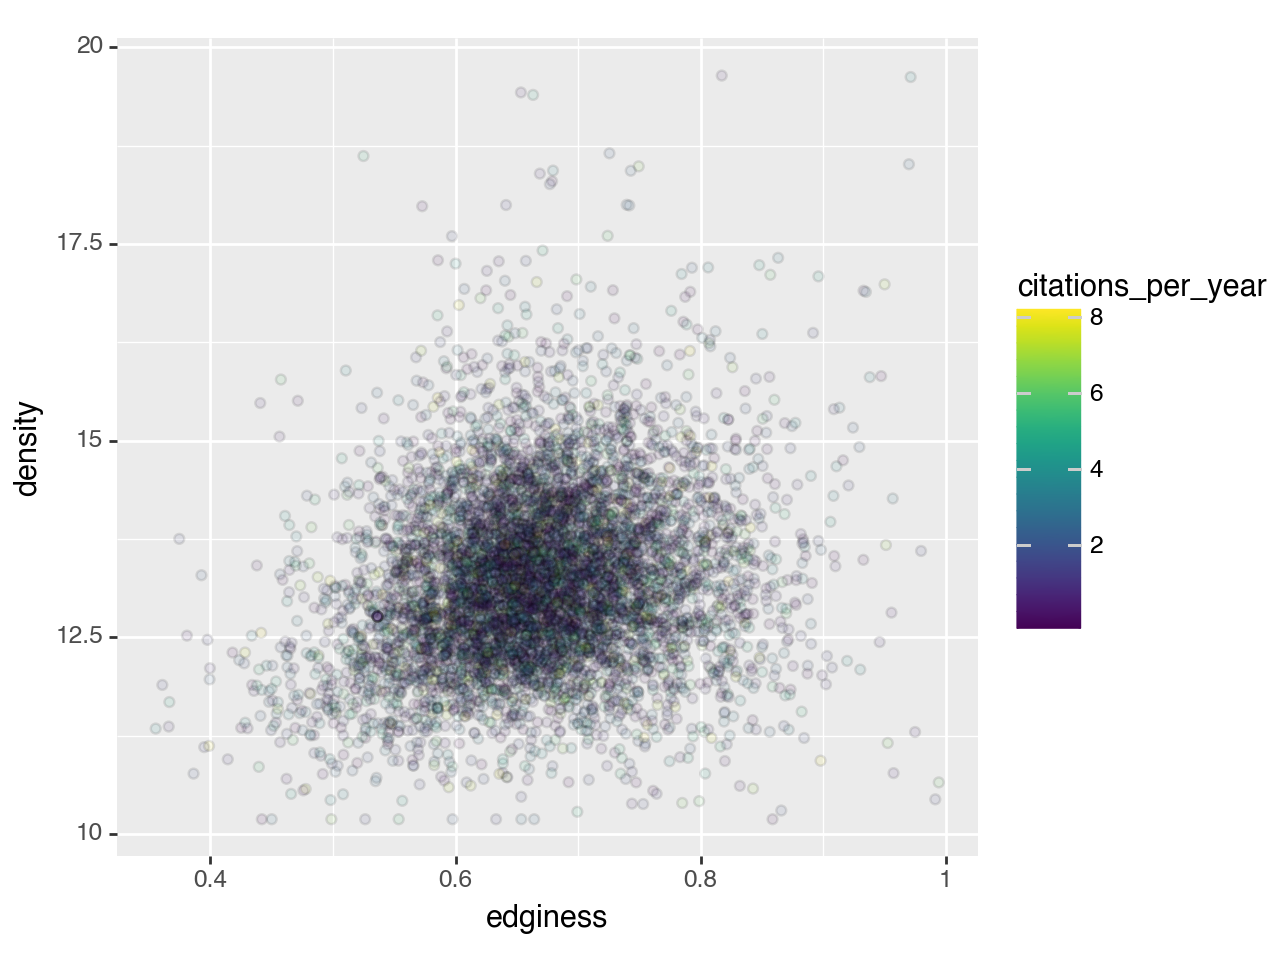

<Figure Size: (640 x 480)>

In [40]:
# not normalized

# also remove citations per year more than a few std devs
# for now just truncate after 100
df_a = df[df["citations_per_year"] <= 8] # or even less

# how to reduce overplotting? Can I make the hotter colors appear on top?
(
    pn.ggplot(
        df_a,
        mapping=pn.aes(x="edginess", y="density")
    )
    + pn.geom_point(
        # fill="blue", 
        mapping=pn.aes(fill="citations_per_year"),
        alpha=0.1,
        )
)

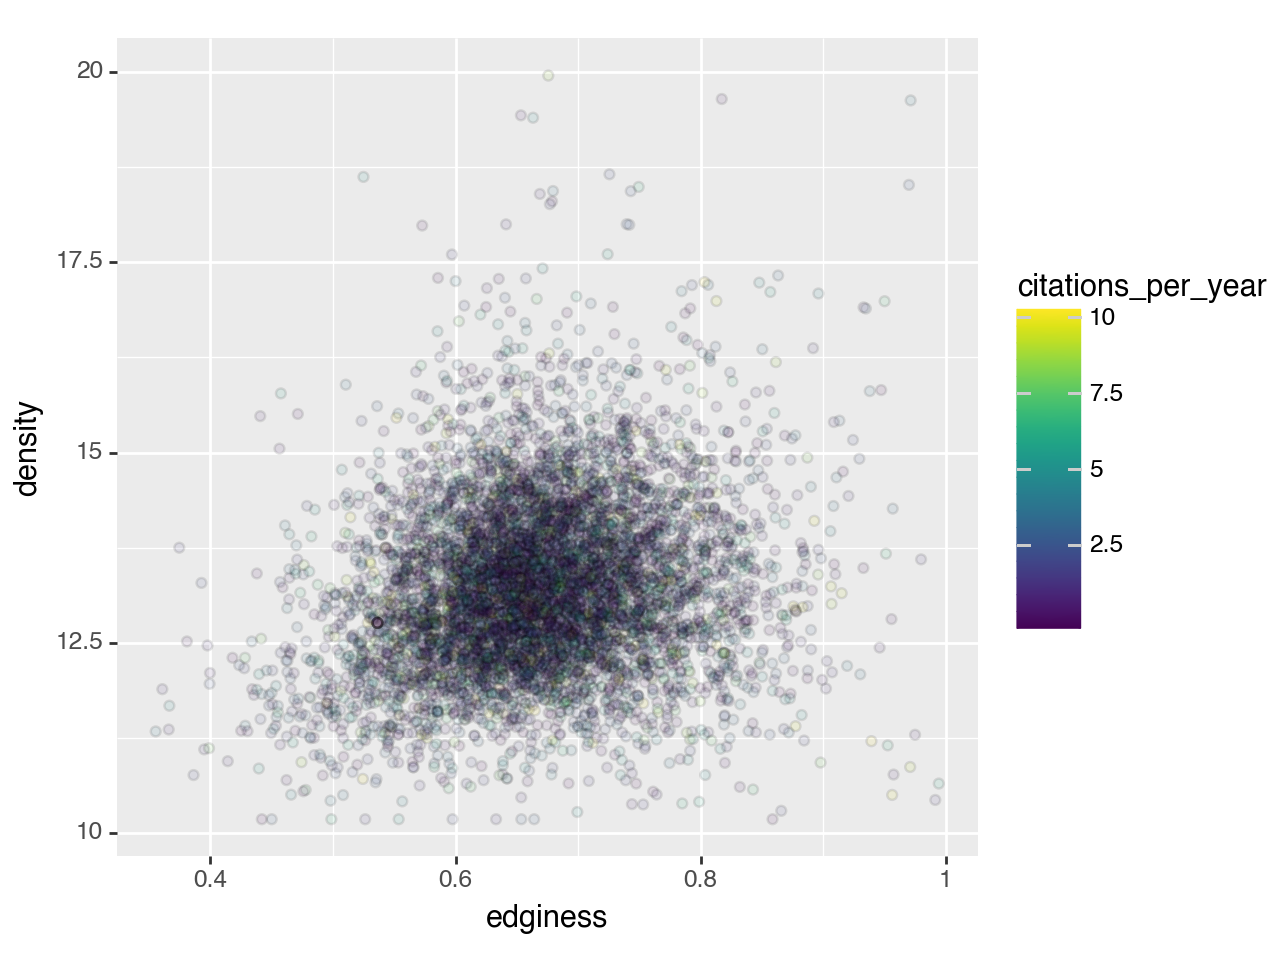

<Figure Size: (640 x 480)>

In [41]:
# let's only plot pubs for high cites per year
df_b = df[df["citations_per_year"] >= 0]
df_b = df[df["citations_per_year"] <= 10]

# how to reduce overplotting? Can I make the hotter colors appear on top?
(
    pn.ggplot(
        df_b,
        mapping=pn.aes(x="edginess", y="density")
    )
    + pn.geom_point(
        # fill="blue", 
        mapping=pn.aes(fill="citations_per_year"),
        alpha=0.1,
        )
)

this does not look like the distribution that zach had.